# Deconvolving simulated data generated with linear functions

In [1]:
# load libraries
import torch
from ternadecov.simulator import *
from ternadecov.time_deconv import *
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.dataset import *
from ternadecov.deconvolution_plotter import *
from ternadecov.parametrization import *
from ternadecov.evaluation import evaluate_with_trajectory
from ternadecov.deconvolution_writer import DeconvolutionWriter
from ternadecov.deconvolution_exporter import DeconvolutionExporter

## Configure

In [2]:
n_iters = 5_000
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

# Load data

In [3]:
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

# Simulation

In [5]:
types = DeconvolutionDatatypeParametrization()

ebov_sc_dataset = SingleCellDataset(
    sc_anndata, 
    sc_celltype_col="Subclustering_reduced", 
    dtype_np=types.dtype_np, dtype = types.dtype, device=types.device)

In [6]:
# Simulate and plot 100 samples from a random trajectory 
# based on linear functions through a softmax

sim_res = simulate_data(
    w_hat_gc = torch.Tensor(ebov_sc_dataset.w_hat_gc),
    num_samples=100, 
    trajectory_type='periodic')



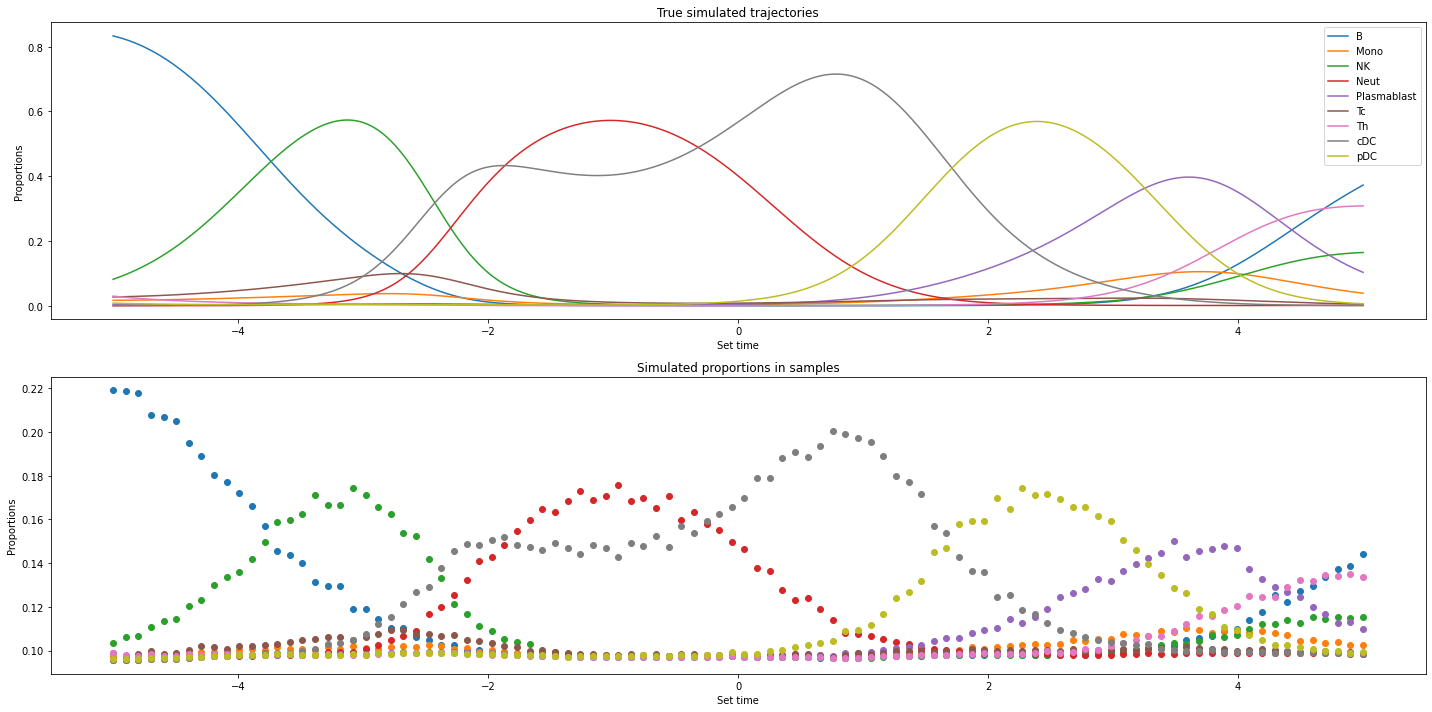

In [7]:
plot_simulated_proportions(sim_res,ebov_sc_dataset )
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [8]:
# Generate input AnnData object from the above simulation
simulated_bulk = generate_anndata_from_sim(
    sim_res, 
    sc_dataset = ebov_sc_dataset)

/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
# Generate a deconvolution dataset
datatype_param = DeconvolutionDatatypeParametrization()

ebov_simulated_dataset = DeconvolutionDataset(
    types=datatype_param,
    parametrization = DeconvolutionDatasetParametrization(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Subclustering_reduced",
        bulk_anndata = simulated_bulk,
        bulk_time_col = "time",
        feature_selection_method = 'common'
    )       
)

log_sc_cutoff: 2
12180 genes selected


In [10]:
pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolutionModel(
    dataset=ebov_simulated_dataset,
    trajectory_model_type='gp',
    hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
    trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
    types=datatype_param)

In [11]:
pseudo_time_reg_deconv_sim.fit_model(
    n_iters=n_iters, 
    verbose=True, 
    log_frequency=1000
)

[step: 0, time: 1 s ] loss: 6988531.25
[step: 1000, time: 78 s ] loss: 5290562.56
[step: 2000, time: 154 s ] loss: 4540428.35
[step: 3000, time: 232 s ] loss: 4229532.30
[step: 4000, time: 315 s ] loss: 4129095.71


# Examine Outputs

In [12]:
plotter = DeconvolutionPlotter(pseudo_time_reg_deconv_sim)

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

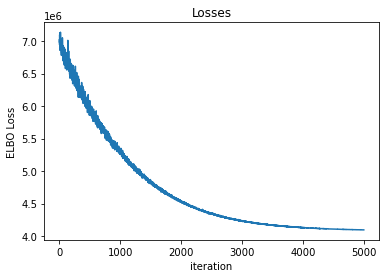

In [13]:
plotter.plot_loss()

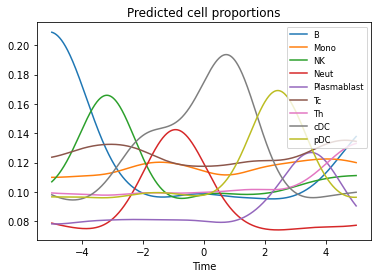

In [14]:
plotter.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

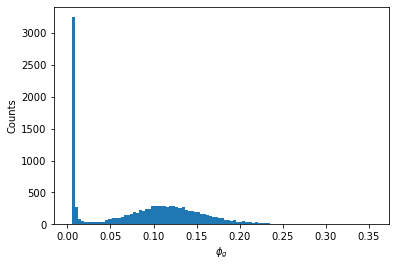

In [15]:
# examine the per-gene dispersions
plotter.plot_phi_g_distribution()

<AxesSubplot:xlabel='$beta_g$', ylabel='Counts'>

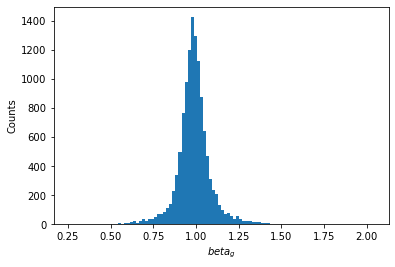

In [16]:
# examine the gene capture coefficients
plotter.plot_beta_g_distribution()